# Danish fire insurance data

In [6]:
import sys
sys.path.insert(0,'/home/pgoffard/BayesSplicedModels/')
%run ../../preamble.py
danish = pd.read_csv("../../Data/Danish/danish.csv").x
tea_thresholds = pd.read_csv("../../Data/Danish/tea_threshold.csv")
import random
random.seed(123)

In [7]:
# The data
X = danish.values
# Model for the bulk distribution
body_model_names = ["Burr"]
# body_model_names = ["Exp", "Gamma"]
body_model_param_names = [["α1","β1", "σ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [
    [bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1),
     bsm.prior_model('gamma',body_model_param_names[0][1], 1, 1),
    bsm.prior_model('gamma',body_model_param_names[0][2], 1, 1)]
]


# Spliced model with free threshold

In [8]:
γ_prior = bsm.prior_model('uniform', "γ", min(X), max(X))

In [9]:
# Model for the tail of the distribution
tail_model_names = ["Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal", "Log-Logistic", "Lomax", "Burr", "Pareto-Tail", "GPD-Tail", "Inverse-Gamma", "Inverse-Weibull"]
# tail_model_names = ["Exp", "Gamma", "Weibull"]

tail_model_param_names = [['λ2'], ["r2", "m2"], ["k2", "β2"], ["μ2", "λ2"], ["μ2", "σ2"], ["β2", "σ2"], ["α2", "σ2"], ["α2", "β2", "σ2"], ["α2"], ["ξ2","σ2"], ["r2", "m2"], ["k2", "β2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [[bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[1][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[1][1], 1, 1)], 
                [bsm.prior_model('gamma',tail_model_param_names[2][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[2][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[3][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[3][1], 1, 1)],
                [bsm.prior_model('normal',tail_model_param_names[4][0], 0, 0.5), bsm.prior_model('gamma',tail_model_param_names[4][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[5][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[5][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[6][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[6][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[7][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[7][1], 1, 1), bsm.prior_model('gamma',tail_model_param_names[7][2], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[8][0], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[9][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[9][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[10][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[10][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[11][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[11][1], 1, 1)]
]
p_prior = bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous", "simple", "disjoint"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"_"+ tail_model_names[j]+"_"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))  
for f in fs:
    f.set_ppf()
f_spliced_dic = dict(zip(f_names, fs))
splits = 1
len(f_names)/splits

36.0

In [10]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 10000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):
    print(f_names[i])
    trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
    return([trace, log_marg, DIC, WAIC])

res = []
for k in range(splits):
    print("Model batch #"+str(k))
    %time res_sub = Parallel(n_jobs=int(len(fs)/splits))(delayed(fit_spliced_models)(i) for i in range(int(k * len(f_names) / splits), int((k+1) * len(f_names)/splits)))
    res += res_sub


Model batch #0
CPU times: user 19.4 s, sys: 384 ms, total: 19.8 s
Wall time: 26min 34s


In [11]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, f_spliced_dic[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
20,Burr-Lomax-disjoint,7,0.899467,-3801.222892,7451.985622,7469.224577,9.999986e-01,556.860046
23,Burr-Burr-disjoint,8,0.824314,-3815.034209,7554.433329,7557.473023,1.004200e-06,707.939692
22,Burr-Burr-simple,7,0.824198,-3816.406888,7552.021447,7558.828490,2.544915e-07,631.098629
34,Burr-Inverse-Weibull-simple,6,0.824532,-3817.041112,7565.217014,7574.413442,1.349689e-07,716.188708
35,Burr-Inverse-Weibull-disjoint,7,0.824461,-3821.510281,7556.961997,7575.552942,1.546315e-09,718.694961
17,Burr-Log-Logistic-disjoint,7,0.824456,-3822.676424,7572.887156,7591.418488,4.817797e-10,755.642878
32,Burr-Inverse-Gamma-disjoint,7,0.824053,-3824.738857,7576.889218,7595.814165,6.125555e-11,820.255271
16,Burr-Log-Logistic-simple,6,0.823865,-3826.466030,7586.850441,7593.168393,1.089040e-11,782.801963
28,Burr-GPD-Tail-simple,6,0.823949,-3829.288362,7612.928622,7615.484978,6.476201e-13,806.092195
29,Burr-GPD-Tail-disjoint,7,0.824427,-3837.096415,7595.091469,7613.758209,2.632243e-16,800.954519


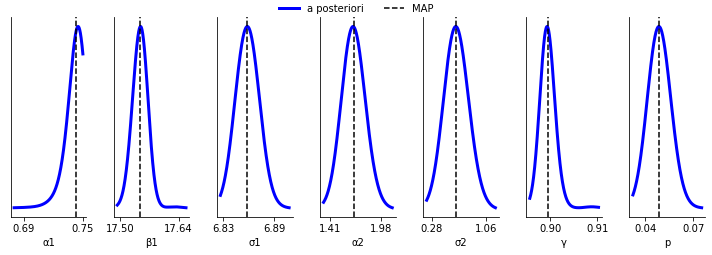

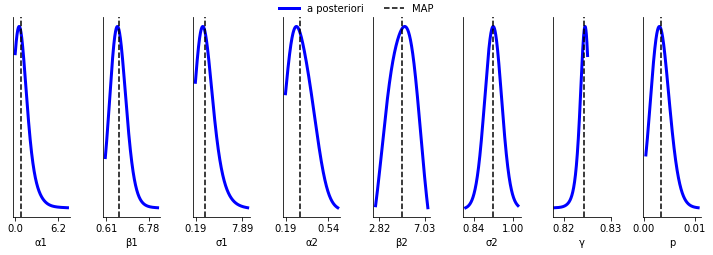

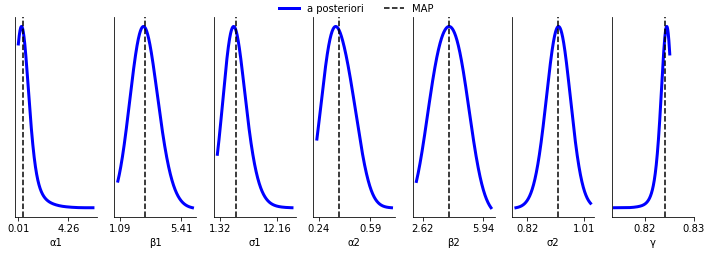

In [12]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"][:3]
for model_name in model_names:
    f, trace = f_spliced_dic[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    bsm.posterior_plots(f, trace)
    # bsm.trace_plots(f, trace)
#     bsm.qq_plot(X, f, trace.mean().values)


# Exportation

In [22]:
import pickle
spliced_model_df.to_csv("../../Data/Danish/danish_splicing_model_fit_"+body_model_names[0]+".csv", sep=',')
with open('../../Data/Danish/trace_danish_'+body_model_names[0]+'.obj', 'wb') as fp:
    pickle.dump(fit_spliced_models_dic, fp)
# with open('../../Data/Danish/f_danish'+body_model_names[0]+'.obj', 'wb') as fp:
#     pickle.dump(f_model_dic, fp)

In [23]:
# loss_model_df_import = pd.read_csv("Data/danish_splicing_model_fit.csv")
# with open('Data/trace_danish.obj', 'rb') as fp:
#     fit_loss_model_dic_import = pickle.load(fp)
# loss_model_df_import
#     # with open('Data/f_danish.obj', 'wb') as fp:
# #     f_model_dic = pickle.load(fp)

In [24]:
# loss_model_df.sort_values(by='WAIC', ascending=True)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
20,Burr-Lomax-disjoint,7,0.899467,-3801.222892,7451.985622,7469.224577,9.999986e-01,556.860046
23,Burr-Burr-disjoint,8,0.824314,-3815.034209,7554.433329,7557.473023,1.004200e-06,707.939692
22,Burr-Burr-simple,7,0.824198,-3816.406888,7552.021447,7558.828490,2.544915e-07,631.098629
34,Burr-Inverse-Weibull-simple,6,0.824532,-3817.041112,7565.217014,7574.413442,1.349689e-07,716.188708
35,Burr-Inverse-Weibull-disjoint,7,0.824461,-3821.510281,7556.961997,7575.552942,1.546315e-09,718.694961
...,...,...,...,...,...,...,...,...
4,Burr-Gamma-simple-amse,6,2.456393,-3954.737382,7828.233308,7856.043546,1.091717e-43,1443.293399
3,Burr-Gamma-continuous-amse,6,2.456393,-3991.561583,7909.502308,7936.005755,1.110613e-59,1677.102525
2,Burr-Exp-disjoint-amse,6,2.456393,-4069.600159,8055.969189,8097.710378,1.425083e-93,1803.116905
1,Burr-Exp-simple-amse,5,2.456393,-4071.603072,8071.854594,8105.888050,1.923029e-94,1849.881783
